## Practical Application of Decision Trees in Financial Risk Management  

Decision‑tree classifiers—often implemented as **Classification and Regression Trees (CART)** —are among the most transparent and intuitive supervised‑learning models available to risk managers.

In credit‑, market‑, and operational‑risk contexts they serve two key purposes:

1. **Interpretability** – every internal node poses a “yes/no” question on an economic or accounting ratio, mirroring the step‑by‑step reasoning of a human analyst.  
2. **Segmented Risk Profiling** – terminal leaves (“pure” nodes) correspond to homogeneous obligor or portfolio segments with distinct risk levels, which can be mapped directly to PD, LGD, or other key‑risk indicators (KRIs).


Assume a training set  

$$
\mathcal{D} = \bigl\{(\mathbf{x}^{(i)},\,y^{(i)})\bigr\}_{i=1}^{N},
\qquad
\mathbf{x}^{(i)}\!\in\!\mathbb{R}^{p},
\;y^{(i)}\!\in\!\{0,1\},
$$  

where $y=1$ denotes an **earnings drop** (our target event) and $\mathbf{x}$ contains financial ratios such as  

| Feature            | Symbol          | Economic meaning     |
|--------------------|-----------------|----------------------|
| Revenue growth     | $g_{\text{rev}}$| Top‑line momentum    |
| Debt‑to‑equity     | $D/E$           | Leverage intensity   |
| OCF margin         | $m_{\text{OCF}}$| Cash‑flow efficiency |

At every node $t$ the algorithm searches over all features $j$ and split points $s$ to maximise the **information gain**

$$
\Delta I(t,j,s)\;=\;I(t)\;-\;
\Bigl(
\dfrac{N_L}{N_t}I(L)\;+\;\dfrac{N_R}{N_t}I(R)
\Bigr),
$$

where $L$ and $R$ are the left/right child nodes and $N_t$ is the sample size in node $t$.  
Typical impurity measures $I(\cdot)$ are  

$$
\text{Entropy:}\;
H(t) = -\!\!\sum_{k=1}^{M} p_{k}(t)\,\log_2 p_{k}(t),
\qquad
\text{Gini:}\;
G(t) = 1-\sum_{k=1}^{M} p_{k}^2(t).
$$

For a **binary** FRM problem ($M=2$) these simplify to  

$$
H(t) = -\bigl[p\log_2 p + (1-p)\log_2(1-p)\bigr],
\qquad
G(t) = 2p(1-p),
$$

with  

$$
p \;=\; \Pr(y=1 \mid t)
      \;=\;
      \frac{\text{number of observations with } y=1 \text{ in node } t}
           {N_t}
      \;=\;
      \frac{1}{N_t}\sum_{i\in t}\mathbf{1}\{y^{(i)}=1\}.
$$

In other words, $p$ is the **empirical proportion** of earnings‑drop cases inside node $t$. It is recalculated after every prospective split because the composition of the child nodes changes.  

> **Interpretation:** a node is pure—and therefore risk‑homogeneous—when $p\in\{0,1\}$, yielding $H=G=0$.

## Imports


In [3]:
import requests
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import re

## Download and save financial statements to Excel

Here we define a mapping of URLs to download quarterly financial data for Apple (AAPL) and save it into an Excel file.
This step involves scraping data from the stockanalysis website.

In [5]:
# Stock symbol and URL mapping for the various statements
ticker = 'aapl'
url_sheet_map = {
    f"https://stockanalysis.com/stocks/{ticker}/?p=quarterly": "Overview",
    f"https://stockanalysis.com/stocks/{ticker}/financials/?p=quarterly": "Income Statement",
    f"https://stockanalysis.com/stocks/{ticker}/financials/balance-sheet/?p=quarterly": "Balance Sheet",
    f"https://stockanalysis.com/stocks/{ticker}/financials/cash-flow-statement/?p=quarterly": "Cash Flow",
    f"https://stockanalysis.com/stocks/{ticker}/financials/ratios/?p=quarterly": "Ratios"
}
excel_file = f"{ticker}_financial_statements.xlsx"

# Write each table found on each URL to a separate sheet in an Excel file.
with pd.ExcelWriter(f"{ticker}_financial_statements.xlsx") as writer:
    # Loop through each URL and its corresponding sheet name
    for url, sheet_name in url_sheet_map.items():
        print(f"Processing: {url}")
        response = requests.get(url)
        response.raise_for_status()  # Ensure the request was successful
        # Parse all tables from the current URL
        tables = pd.read_html(response.text)
        print(f"Found {len(tables)} tables at {url}.")
        # If multiple tables, we write them sequentially in the same sheet
        startrow = 0  # Initial row position for writing
        # Use a list to collect dataframes if you prefer concatenation, but here we write them one after another
        for idx, table in enumerate(tables):
            # Optionally, add a header row in the Excel sheet to indicate table separation
            header = pd.DataFrame({f"Table {idx} from {sheet_name}": []})
            header.to_excel(writer, sheet_name=sheet_name, startrow=startrow)
            startrow += 1  # Move down one row for the table data
            # Write the table to the current sheet starting at the designated row
            table.to_excel(writer, sheet_name=sheet_name, startrow=startrow)
            # Update the startrow for the next table (current table rows + 2 extra rows as spacer)
            startrow += len(table.index) + 2
        print("All tables have been saved into 'tables_by_url.xlsx', each URL in its own sheet.")

## --- Step 2: Clean and load the sheets from Excel ---
TICKER = "AAPL"
EXCEL = f"{TICKER}_financial_statements.xlsx"
FY_COL = "FY2024"  # Adjust as necessary

Processing: https://stockanalysis.com/stocks/aapl/?p=quarterly
Found 2 tables at https://stockanalysis.com/stocks/aapl/?p=quarterly.
All tables have been saved into 'tables_by_url.xlsx', each URL in its own sheet.
Processing: https://stockanalysis.com/stocks/aapl/financials/?p=quarterly
Found 1 tables at https://stockanalysis.com/stocks/aapl/financials/?p=quarterly.
All tables have been saved into 'tables_by_url.xlsx', each URL in its own sheet.
Processing: https://stockanalysis.com/stocks/aapl/financials/balance-sheet/?p=quarterly
Found 1 tables at https://stockanalysis.com/stocks/aapl/financials/balance-sheet/?p=quarterly.
All tables have been saved into 'tables_by_url.xlsx', each URL in its own sheet.
Processing: https://stockanalysis.com/stocks/aapl/financials/cash-flow-statement/?p=quarterly
Found 1 tables at https://stockanalysis.com/stocks/aapl/financials/cash-flow-statement/?p=quarterly.
All tables have been saved into 'tables_by_url.xlsx', each URL in its own sheet.
Processing

In [76]:
# Stock symbol and URL mapping for the various statements
ticker = 'aapl'
url_sheet_map = {
    f"https://stockanalysis.com/stocks/{ticker}/?p=quarterly": "Overview",
    f"https://stockanalysis.com/stocks/{ticker}/financials/?p=quarterly": "Income Statement",
    f"https://stockanalysis.com/stocks/{ticker}/financials/balance-sheet/?p=quarterly": "Balance Sheet",
    f"https://stockanalysis.com/stocks/{ticker}/financials/cash-flow-statement/?p=quarterly": "Cash Flow",
    f"https://stockanalysis.com/stocks/{ticker}/financials/ratios/?p=quarterly": "Ratios"
}
excel_file = f"{ticker}_financial_statements.xlsx"

# Write each table found on each URL to a separate sheet in an Excel file.
with pd.ExcelWriter(f"{ticker}_financial_statements.xlsx") as writer:
    # Loop through each URL and its corresponding sheet name
    for url, sheet_name in url_sheet_map.items():
        print(f"Processing: {url}")
        response = requests.get(url)
        response.raise_for_status()  # Ensure the request was successful
        # Parse all tables from the current URL
        tables = pd.read_html(response.text)
        print(f"Found {len(tables)} tables at {url}.")
        # If multiple tables, we write them sequentially in the same sheet
        startrow = 0  # Initial row position for writing
        # Use a list to collect dataframes if you prefer concatenation, but here we write them one after another
        for idx, table in enumerate(tables):
            # Optionally, add a header row in the Excel sheet to indicate table separation
            header = pd.DataFrame({f"Table {idx} from {sheet_name}": []})
            header.to_excel(writer, sheet_name=sheet_name, startrow=startrow)
            startrow += 1  # Move down one row for the table data
            # Write the table to the current sheet starting at the designated row
            table.to_excel(writer, sheet_name=sheet_name, startrow=startrow)
            # Update the startrow for the next table (current table rows + 2 extra rows as spacer)
            startrow += len(table.index) + 2
        print("All tables have been saved into 'tables_by_url.xlsx', each URL in its own sheet.")

Processing: https://stockanalysis.com/stocks/aapl/?p=quarterly
Found 2 tables at https://stockanalysis.com/stocks/aapl/?p=quarterly.
All tables have been saved into 'tables_by_url.xlsx', each URL in its own sheet.
Processing: https://stockanalysis.com/stocks/aapl/financials/?p=quarterly
Found 1 tables at https://stockanalysis.com/stocks/aapl/financials/?p=quarterly.
All tables have been saved into 'tables_by_url.xlsx', each URL in its own sheet.
Processing: https://stockanalysis.com/stocks/aapl/financials/balance-sheet/?p=quarterly
Found 1 tables at https://stockanalysis.com/stocks/aapl/financials/balance-sheet/?p=quarterly.
All tables have been saved into 'tables_by_url.xlsx', each URL in its own sheet.
Processing: https://stockanalysis.com/stocks/aapl/financials/cash-flow-statement/?p=quarterly
Found 1 tables at https://stockanalysis.com/stocks/aapl/financials/cash-flow-statement/?p=quarterly.
All tables have been saved into 'tables_by_url.xlsx', each URL in its own sheet.
Processing

## Clean and load the sheets from Excel

In this section, we define a function to clean and prepare the financial data for further processing.
The function reads the Excel file, processes the relevant sheets, and organizes the data.

In [78]:
TICKER = "AAPL"
EXCEL = f"{TICKER}_financial_statements.xlsx"
FY_COL = "FY2024"  # Adjust as necessary

In [80]:
# --- Helper Functions ---
def parse_value(val):
    if isinstance(val, str):
        val = val.replace(",", "").strip()
        if val in ['-', '', 'NA', 'N/A']:
            return np.nan
        if "%" in val:
            try: 
                return float(val.replace("%", "").strip()) / 100
            except: 
                return np.nan
        m = {'B': 1e9, 'M': 1e6, 'T': 1e12}
        if val[-1] in m:
            try: 
                return float(val[:-1].strip()) * m[val[-1]]
            except: 
                return np.nan
        try: 
            return float(val) * 1e6 if val[-1].isdigit() else np.nan
        except: 
            return np.nan
    return np.nan if pd.isna(val) else val

def clean_sheet(sheet, file):
    # Read the sheet using the first two rows (0 and 1) as headers.
    # (Adjust header=[0,1] if your file’s first two rows contain the date information.)
    df = pd.read_excel(EXCEL, sheet_name=sheet, header=[1, 2])
    df = df.iloc[1:].reset_index(drop=True)
    # Flatten the multi-index columns by joining the two header levels.
    # For each column (a tuple), join non-empty parts with a space.
    df.columns = [
        ' '.join(str(part).strip() for part in col if pd.notna(part) and str(part).strip() != '')
        for col in df.columns.values
    ]
    return df

def get_val(df, key, col=FY_COL, default=None):
    row = df[df["Item"].str.contains(key, case=False, na=False)]
    return row[col].values[0] if not row.empty else default

# --- Load Data ---
fin = clean_sheet("Income Statement", EXCEL)
fin = fin.set_index(fin.columns[1])
fin = fin.drop(fin.columns[0], axis=1)
fin.index.name = 'Item'

bal = clean_sheet("Balance Sheet", EXCEL)
bal = bal.set_index(bal.columns[1])
bal = bal.drop(bal.columns[0], axis=1)
bal.index.name = 'Item'

cf = clean_sheet("Cash Flow", EXCEL)
cf = cf.set_index(cf.columns[1])
cf = cf.drop(cf.columns[0], axis=1)
cf.index.name = 'Item'

## Process and extract metrics from each statement 
In this section, we extract relevant financial metrics from the Income Statement, Balance Sheet, and Cash Flow statements


In [83]:
# For the Income Statement, extract rows for "Revenue" and "Net Income".
revenue_row = fin[fin.index.str.strip().str.match(r"^Revenue$", case=False, na=False)]
rev_df = revenue_row.T.reset_index().rename(columns={'index': 'Period', revenue_row.index[0]: 'Revenue'})

net_income_row = fin[fin.index.str.strip().str.match(r"^Net Income$", case=False, na=False)]
ni_df = net_income_row.T.reset_index().rename(columns={'index': 'Period', net_income_row.index[0]: 'Net Income'})

# For the Balance Sheet, extract rows for "Total Liabilities" and "Total Equity"
liab_row = bal.loc[bal.index.str.strip().str.match(r"^Total Liabilities$", case=False, na=False)]
liab_df = liab_row.T.reset_index().rename(columns={'index': 'Period', liab_row.index[0]: 'Total Liabilities'})

equity_row = bal.loc[bal.index.str.strip().str.match(r"^Shareholders' Equity$", case=False, na=False)]
equity_df = equity_row.T.reset_index().rename(columns={'index': 'Period', equity_row.index[0]: "Shareholders' Equity"})

# For the Cash Flow, extract the row for "Operating Cash Flow"
ocf_row = cf.loc[cf.index.str.strip().str.match(r"^Operating Cash Flow$", case=False, na=False)]
ocf_df = ocf_row.T.reset_index().rename(columns={'index': 'Period', ocf_row.index[0]: "Operating Cash Flow"})

## Merge the metrics by period

We now merge all the metrics into a single DataFrame to have all financial information per period.

In [86]:
# Merge on the "Period" column
merged = rev_df.merge(ni_df, on="Period", suffixes=("_Revenue", "_NetIncome"))
merged = merged.merge(liab_df, on="Period")
merged = merged.merge(equity_df, on="Period")
merged = merged.merge(ocf_df, on="Period")

# Rename columns if needed (here we assume the first non-"Item" column represents the value)
merged.rename(columns={
    merged.columns[1]: "Revenue",
    merged.columns[2]: "Net Income",
    merged.columns[3]: "Total Liabilities",
    merged.columns[4]: "Total Equity",
    merged.columns[5]: "Operating Cash Flow"
}, inplace=True)

# Convert key columns to numeric
for col in ["Revenue", "Net Income", "Total Liabilities", "Total Equity", "Operating Cash Flow"]:
    merged[col] = pd.to_numeric(merged[col], errors='coerce')

## Process Period Dates

Here we extract and clean the date for each period, expecting a format like "Sep 28, 2024", which will be parsed and added as a new column.

In [89]:
# Define a function to extract the full period-ending date.
def extract_date(period_str):
    # This regex attempts to capture the date at the end of the string.
    # It expects a pattern like "Sep 28, 2024" at the very end.
    m = re.search(r"([A-Za-z]{3} \d{1,2}, \d{4})$", period_str)
    if m:
        return m.group(1)
    else:
        return None

# Create a new Date column in 'merged' by extracting and converting the date.
merged["Date"] = merged["Period"].apply(lambda x: pd.to_datetime(extract_date(x), errors='coerce'))

# Sort the merged DataFrame in chronological order (oldest to newest) based on the extracted Date.
merged = merged.sort_values("Date", ascending=True).reset_index(drop=True)

# Compute debt-to-equity ratio
merged["Debt_to_Equity"] = merged["Total Liabilities"] / merged["Total Equity"]

# Compute revenue growth as percent change (assuming periods are in chronological order)
merged["Revenue_growth"] = merged["Revenue"].pct_change()

# Compute Operating Cash Flow margin
merged["OCF_margin"] = merged["Operating Cash Flow"] / merged["Revenue"]

# Define Earnings Drop: 1 if current period's Net Income is lower than previous period's
merged["Earnings_drop"] = (merged["Net Income"] < merged["Net Income"].shift(1)).astype(int)

# Drop the first period (which has no previous period to compare)
model_df = merged.dropna(subset=["Revenue_growth", "Debt_to_Equity", "OCF_margin", "Earnings_drop"])

print("Merged financial data for modeling:")
print(model_df[['Period', 'Date', 'Revenue', 'Net Income', 'Debt_to_Equity', 'Revenue_growth', 'OCF_margin', 'Earnings_drop']].to_string(index=False))

Merged financial data for modeling:
                      Period       Date  Revenue  Net Income  Debt_to_Equity  Revenue_growth  OCF_margin  Earnings_drop
Q3 2020 Jun '20 Jun 27, 2020 2020-06-27  59685.0     11253.0        3.390360        0.023528    0.272615              0
Q4 2020 Sep '20 Sep 26, 2020 2020-09-26  64698.0     12673.0        3.957039        0.083991    0.318031              0
Q1 2021 Dec '20 Dec 26, 2020 2020-12-26 111439.0     28755.0        4.346309        0.722449    0.347841              0
Q2 2021 Mar '21 Mar 27, 2021 2021-03-27  89584.0     23630.0        3.873775       -0.196116    0.267693              1
Q3 2021 Jun '21 Jun 26, 2021 2021-06-26  81434.0     21744.0        4.131301       -0.090976    0.259032              1
Q4 2021 Sep '21 Sep 25, 2021 2021-09-25  83360.0     20551.0        4.563512        0.023651    0.242322              1
Q1 2022 Dec '21 Dec 25, 2021 2021-12-25 123945.0     34630.0        4.299324        0.486864    0.378926              0
Q2 2

## Build a multi-feature decision tree

Compute key financial ratios such as Debt-to-Equity, Revenue Growth, and OCF Margin.
We also define a target variable 'Earnings_drop' (1 if net income decreased, otherwise 0).

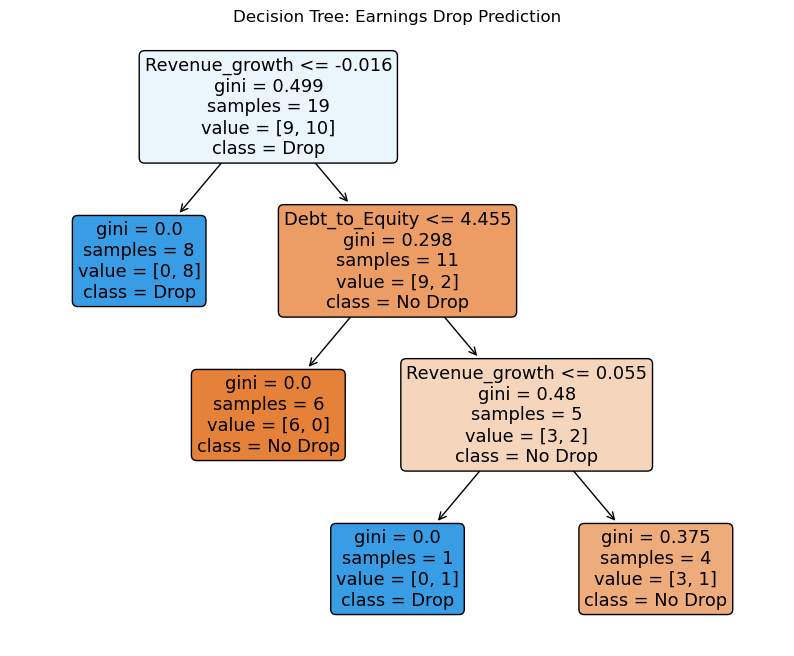

In [92]:
features = ['Revenue_growth', 'Debt_to_Equity', 'OCF_margin']
target = 'Earnings_drop'
X = model_df[features]
y = model_df[target]

clf = DecisionTreeClassifier(criterion='gini', random_state=0, max_depth=3)
clf.fit(X, y)

plt.figure(figsize=(10, 8))
plot_tree(clf, feature_names=features, class_names=["No Drop", "Drop"], filled=True, rounded=True)
plt.title("Decision Tree: Earnings Drop Prediction")
plt.show()